## Plot gene set comparison

In this notebook, we want to compare prediction of mutations in the genes from our cancer gene set, derived from [Vogelstein et al. 2013](https://science.sciencemag.org/content/339/6127/1546), with two other sets of potentially relevant genes. These are:

* The most frequently mutated genes in TCGA
* A set of random genes in TCGA, that meet our mutation count threshold for 2 or more cancer types

We selected enough genes in each of these gene sets to (approximately) match the count of the Vogelstein et al. gene set.

In these experiments we only used gene expression data, and we used the set of TCGA samples that have both gene expression and MC3 somatic mutation data. The files analyzed in this notebook were generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
vogelstein_results_dir = Path(cfg.results_dirs['mutation'],
                              'vogelstein_expression_only',
                              'gene').resolve()
top_50_results_dir = Path(cfg.results_dirs['mutation'],
                          'top_50_expression_only',
                          'gene').resolve()
random_50_results_dir = Path(cfg.results_dirs['mutation'],
                             '50_random_expression_only',
                             'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
vogelstein_df = au.load_stratified_prediction_results(vogelstein_results_dir, 'gene')
vogelstein_df = vogelstein_df[vogelstein_df.training_data.isin(['expression'])]
vogelstein_df['gene_set'] = 'vogelstein'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(vogelstein_df.shape)
print(vogelstein_df.seed.unique())
print(vogelstein_df.training_data.unique())
print(len(vogelstein_df.identifier.unique()))
vogelstein_df.head()

(4920, 10)
[42  1]
['expression']
106


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.99386,0.93793,MAP3K1,expression,signal,42,train,0,gene,vogelstein
1,0.74244,0.34514,MAP3K1,expression,signal,42,test,0,gene,vogelstein
2,0.65156,0.20172,MAP3K1,expression,signal,42,cv,0,gene,vogelstein
3,0.99603,0.92337,MAP3K1,expression,signal,42,train,1,gene,vogelstein
4,0.66892,0.31002,MAP3K1,expression,signal,42,test,1,gene,vogelstein


In [4]:
# load raw data
top_50_df = au.load_stratified_prediction_results(top_50_results_dir, 'gene')
top_50_df = top_50_df[top_50_df.training_data.isin(['expression'])]
top_50_df['gene_set'] = 'top_50'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(top_50_df.shape)
print(top_50_df.seed.unique())
print(top_50_df.training_data.unique())
print(len(top_50_df.identifier.unique()))
top_50_df.head()

(5136, 10)
[42  1]
['expression']
107


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.50544,0.47987,TP53,expression,shuffled,42,train,0,gene,top_50
1,0.52804,0.50126,TP53,expression,shuffled,42,test,0,gene,top_50
2,0.50844,0.48510,TP53,expression,shuffled,42,cv,0,gene,top_50
3,0.50000,0.48132,TP53,expression,shuffled,42,train,1,gene,top_50
4,0.50000,0.46177,TP53,expression,shuffled,42,test,1,gene,top_50


In [5]:
# load raw data
random_50_df = au.load_stratified_prediction_results(random_50_results_dir, 'gene')
random_50_df = random_50_df[random_50_df.training_data.isin(['expression'])]
random_50_df['gene_set'] = 'random_50'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(random_50_df.shape)
print(random_50_df.seed.unique())
print(random_50_df.training_data.unique())
print(len(random_50_df.identifier.unique()))
random_50_df.head()

(5136, 10)
[ 1 42]
['expression']
107


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.79660,0.293060,TMEM132D,expression,shuffled,1,train,0,gene,random_50
1,0.46214,0.076815,TMEM132D,expression,shuffled,1,test,0,gene,random_50
2,0.55997,0.074921,TMEM132D,expression,shuffled,1,cv,0,gene,random_50
3,0.59354,0.160430,TMEM132D,expression,shuffled,1,train,1,gene,random_50
4,0.49272,0.063990,TMEM132D,expression,shuffled,1,test,1,gene,random_50


In [6]:
# combine results dataframes
results_df = (
    pd.concat((vogelstein_df, top_50_df, random_50_df))
      .drop(columns=['training_data', 'experiment'])
)

# for each gene set, compare signal vs. shuffled + do statistical testing
all_results_df = pd.DataFrame()
for gene_set in results_df.gene_set.unique():
    data_results_df = au.compare_results(results_df[results_df.gene_set == gene_set],
                                         identifier='identifier',
                                         metric='aupr',
                                         correction=True,
                                         correction_method='fdr_bh',
                                         correction_alpha=SIG_ALPHA,
                                         verbose=True)
    data_results_df['gene_set'] = gene_set
    data_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    all_results_df = pd.concat((all_results_df, data_results_df))
    
all_results_df.sort_values(by='gene_set', inplace=True)
all_results_df.sort_values(by='p_value').head(10)

shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for MLH1, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH2, skipping
shapes unequal for PAX5, skipping
shapes unequal for PTPN11, skipping
shapes unequal for RUNX1, skipping


,gene,delta_mean,p_value,corr_pval,reject_null,gene_set
94,TP53,0.407729,5.638959e-20,5.494995e-18,True,vogelstein
16,BRAF,0.617245,1.121428e-19,5.494995e-18,True,vogelstein
97,TP53,0.403219,2.516831e-18,2.693009e-16,True,top_50
26,CTNNB1,0.593111,3.305822e-18,9.862705e-17,True,vogelstein
29,EGFR,0.584966,4.025594e-18,9.862705e-17,True,vogelstein
8,BRAF,0.610924,1.166317e-17,1.247959e-15,True,random_50
12,BRAF,0.598210,2.891466e-17,1.546934e-15,True,top_50
73,PIK3CA,0.335805,1.217084e-16,2.307799e-15,True,vogelstein
6,ARID1A,0.424040,1.412938e-16,2.307799e-15,True,vogelstein
31,CTNNB1,0.598305,4.188978e-16,2.241103e-14,True,random_50


Vogelstein et al.: 60/98 (0.6122)
random genes: 10/107 (0.0935)
top mutated genes: 43/107 (0.4019)


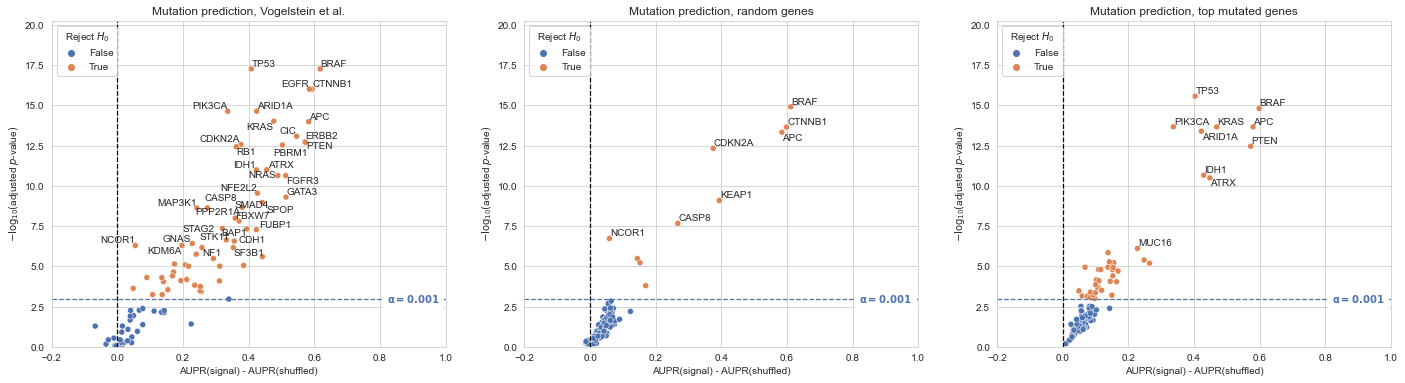

In [7]:
all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)

names_map = {
    'top_50': 'top mutated genes',
    'random_50': 'random genes',
    'vogelstein': 'Vogelstein et al.'
}

all_results_df.gene_set.replace(names_map, inplace=True)

sns.set({'figure.figsize': (24, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

# all plots should have the same axes for a fair comparison
xlim = (-0.2, 1.0)
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA / 1000):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot mutation prediction from expression, in a volcano-like plot
for ix, gene_set in enumerate(sorted(all_results_df.gene_set.unique())):
    ax = axarr[ix]
    data_results_df = all_results_df[all_results_df.gene_set == gene_set]
    sns.scatterplot(data=data_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax)
    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.9, -np.log10(SIG_ALPHA)+0.01,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor())
    ax.set_xlabel('AUPR(signal) - AUPR(shuffled)')
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=r'Reject $H_0$', loc='upper left')
    ax.set_title(r'Mutation prediction, {}'.format(gene_set))

    # label genes and adjust text to not overlap
    # automatic alignment isn't perfect, can align by hand in inkscape if necessary
    text_labels = label_points(data_results_df['delta_mean'],
                               data_results_df['nlog10_p'],
                               data_results_df.gene,
                               ax)
    
    adjust_text(text_labels,
                ax=ax, 
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{} ({:.4f})'.format(
        gene_set,
        np.count_nonzero(data_results_df.reject_null),
        data_results_df.shape[0],
        np.count_nonzero(data_results_df.reject_null) / data_results_df.shape[0]
    ))

(-0.2, 0.667245)

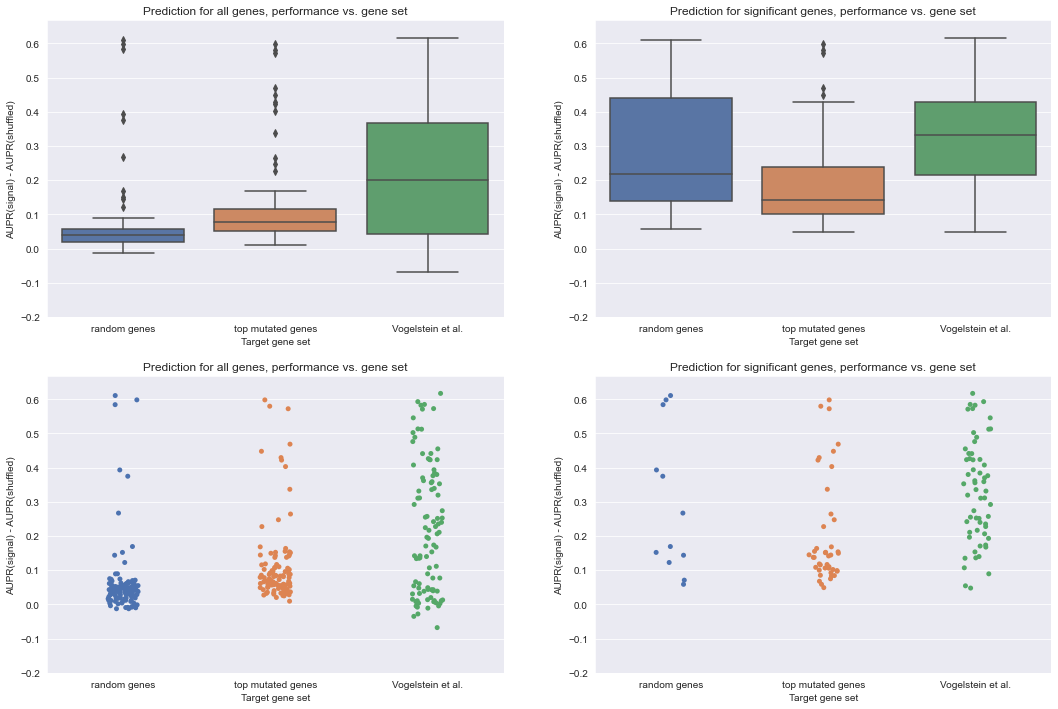

In [8]:
sns.set({'figure.figsize': (18, 12)})
fig, axarr = plt.subplots(2, 2)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0, 0]
sns.boxplot(data=all_results_df, x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Prediction for all genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

# plot mean performance for genes that are significant for at least one data type
ax = axarr[0, 1]
gene_list = all_results_df[all_results_df.reject_null == True].gene.unique()
sns.boxplot(data=all_results_df[all_results_df.gene.isin(gene_list)],
            x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Prediction for significant genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

ax = axarr[1, 0]
sns.stripplot(data=all_results_df, x='gene_set', y='delta_mean', dodge=True, ax=ax)
ax.set_title('Prediction for all genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

ax = axarr[1, 1]
sns.stripplot(data=all_results_df[all_results_df.gene.isin(gene_list)],
              x='gene_set', y='delta_mean', dodge=True, ax=ax)
ax.set_title('Prediction for significant genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

### Calculate gene set overlap

Of the significantly predictable genes in the top/random gene sets, how many of them are in the Vogelstein gene set?

In [9]:
from venn import venn

random genes 107
top mutated genes 107
Vogelstein et al. 98


Text(0.5, 1.0, 'Gene overlap between all genes in gene set')

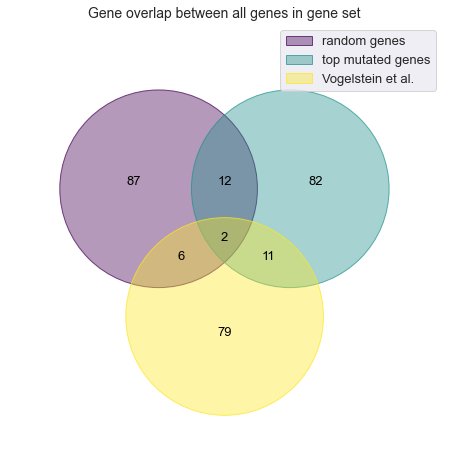

In [10]:
# first look at overlap of all genes
genes_in_gene_set = {}
for gene_set in all_results_df.gene_set.unique():
    gene_list = all_results_df[all_results_df.gene_set == gene_set].gene.unique()
    print(gene_set, len(gene_list))
    genes_in_gene_set[gene_set] = set(gene_list)
    
venn(genes_in_gene_set)
plt.title('Gene overlap between all genes in gene set', size=14)

random genes 10
top mutated genes 43
Vogelstein et al. 60


Text(0.5, 1.0, 'Gene overlap between significantly predictable genes in gene set')

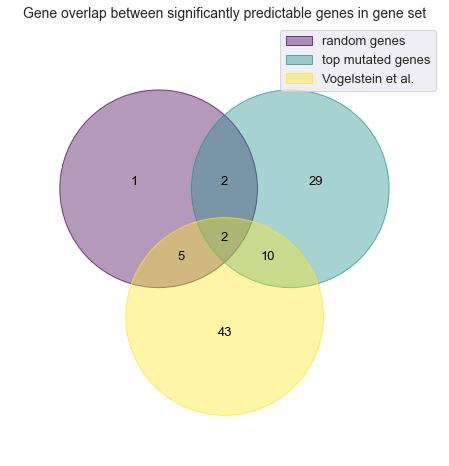

In [11]:
# now look at overlap of significant genes
genes_in_gene_set = {}
for gene_set in all_results_df.gene_set.unique():
    gene_list = all_results_df[(all_results_df.gene_set == gene_set) &
                               (all_results_df.reject_null)].gene.unique()
    print(gene_set, len(gene_list))
    genes_in_gene_set[gene_set] = set(gene_list)
    
venn(genes_in_gene_set)
plt.title('Gene overlap between significantly predictable genes in gene set', size=14)